# 🖼️ Image Classification with ResNeXt Model

In this notebook, we implement a ResNeXt model for image classification using the Intel Image Classification dataset. We load and preprocess the data, train the ResNeXt model, and evaluate its performance. Let's explore advanced image classification with deep learning! 🚀

In [2]:

# Import required libraries 📚
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import matplotlib.pyplot as plt  # For plotting 🖼️
%matplotlib inline

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


In [ ]:

# Load training data with transformations for data augmentation
train = ImageFolder("../input/intel-image-classification/seg_train", transform=tt.Compose([
    tt.Resize(256),
    tt.RandomCrop(225),
    tt.ToTensor(),
]))
train_dl = DataLoader(train, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

# Function to calculate mean and standard deviation for normalization
def get_mean_std(dl):
    sum_, squared_sum, batches = 0, 0, 0
    for data, _ in dl:
        sum_ += torch.mean(data, dim=([0, 2, 3]))
        squared_sum += torch.mean(data ** 2, dim=([0, 2, 3]))
        batches += 1
        
    mean = sum_ / batches
    std = (squared_sum / batches - mean ** 2) ** 0.5
    return mean, std

# Calculate and display mean and std for normalization
mean, std = get_mean_std(train_dl)
print("Mean:", mean)
print("Standard Deviation:", std)


In [ ]:

# Define transformations with calculated normalization statistics
stats = ((0.4951, 0.4982, 0.4979), (0.2482, 0.2467, 0.2807))
train_transform = tt.Compose([
    tt.Resize(150),
    tt.RandomCrop(150),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats, inplace=True)
])

test_transform = tt.Compose([
    tt.Resize(150),
    tt.RandomCrop(150),
    tt.ToTensor(),
    tt.Normalize(*stats, inplace=True)
])


### Data Preparation 📦

We load the training and test datasets and apply the transformations defined above. These transformations include resizing, random cropping, horizontal flipping, and normalization based on the calculated mean and standard deviation.

In [ ]:
train = ImageFolder("../input/intel-image-classification/seg_train/seg_train", transform = train_transform)
test = ImageFolder("../input/intel-image-classification/seg_test/seg_test",transform = test_transform)

In [ ]:
random_seed = 27
torch.manual_seed(random_seed);

In [ ]:
val_size = int(len(train) * 0.2)
train_size = len(train) - val_size

train_ds, val_ds = random_split(train, [train_size, val_size])
len(train_ds), len(val_ds)

In [ ]:
batch_size = 64

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test, batch_size*2, num_workers=2, pin_memory=True)

In [3]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

In [ ]:
show_batch(train_dl)

In [4]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [5]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
# or
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnext101_32x8d', pretrained=True)
# model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [6]:

train_transform = tt.Compose([
    tt.Resize(150),
    tt.RandomCrop(150),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],inplace=True)
])

test_transform = tt.Compose([
    tt.Resize(150),
    tt.RandomCrop(150),
    tt.ToTensor(),
    tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],inplace=True)
])

train = ImageFolder("../input/intel-image-classification/seg_train/seg_train", transform = train_transform)
test = ImageFolder("../input/intel-image-classification/seg_test/seg_test",transform = test_transform)

random_seed = 27
torch.manual_seed(random_seed);

val_size = int(len(train) * 0.2)
train_size = len(train) - val_size

train_ds, val_ds = random_split(train, [train_size, val_size])

In [7]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test, batch_size*2, num_workers=2, pin_memory=True)

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [9]:
def training_step(model, batch):
    images, labels = batch
    out = model(images)
    loss = F.cross_entropy(out, labels)
    return loss

In [10]:
def validation_step(model, batch):
    images, labels = batch
    out = model(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}

In [11]:
def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

In [12]:
def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [15]:
no_of_classes = len(train.classes)
no_of_classes

6

In [16]:
model = nn.Sequential(
    model,
    nn.Linear(1000, 512, bias=True),
    nn.Linear(512, 64, bias=True),
    nn.Linear(64, 6, bias=True)
)
model = to_device(model, device)
model

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [15]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model, batch) for batch in val_loader]
    return validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(filter(lambda p: p.requires_grad, model.parameters()), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = training_step(model, batch)
            train_losses.append(loss)
            loss.backward()
            
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        epoch_end(model, epoch, result)
        history.append(result)
    return history

In [18]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.0455002784729004, 'val_acc': 0.2183919996023178}]

In [19]:
epochs = 100
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-8
opt_func = torch.optim.Adam

In [21]:
model

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [20]:
for index, param in enumerate(model.parameters()):
    param.requires_grad = True

In [23]:
for index, param in enumerate(model.parameters()):
    print(index, param.size())

0 torch.Size([64, 3, 7, 7])
1 torch.Size([64])
2 torch.Size([64])
3 torch.Size([128, 64, 1, 1])
4 torch.Size([128])
5 torch.Size([128])
6 torch.Size([128, 4, 3, 3])
7 torch.Size([128])
8 torch.Size([128])
9 torch.Size([256, 128, 1, 1])
10 torch.Size([256])
11 torch.Size([256])
12 torch.Size([256, 64, 1, 1])
13 torch.Size([256])
14 torch.Size([256])
15 torch.Size([128, 256, 1, 1])
16 torch.Size([128])
17 torch.Size([128])
18 torch.Size([128, 4, 3, 3])
19 torch.Size([128])
20 torch.Size([128])
21 torch.Size([256, 128, 1, 1])
22 torch.Size([256])
23 torch.Size([256])
24 torch.Size([128, 256, 1, 1])
25 torch.Size([128])
26 torch.Size([128])
27 torch.Size([128, 4, 3, 3])
28 torch.Size([128])
29 torch.Size([128])
30 torch.Size([256, 128, 1, 1])
31 torch.Size([256])
32 torch.Size([256])
33 torch.Size([256, 256, 1, 1])
34 torch.Size([256])
35 torch.Size([256])
36 torch.Size([256, 8, 3, 3])
37 torch.Size([256])
38 torch.Size([256])
39 torch.Size([512, 256, 1, 1])
40 torch.Size([512])
41 torch.S

In [24]:
for index, param in enumerate(model.parameters()):
    if index < 161:
        param.requires_grad = False

In [25]:
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


In [26]:
history += fit_one_cycle(20, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.01000, train_loss: 1.8592, val_loss: 0.4330, val_acc: 0.8489
Epoch [1], last_lr: 0.01000, train_loss: 0.4150, val_loss: 0.4201, val_acc: 0.8435
Epoch [2], last_lr: 0.01000, train_loss: 0.4192, val_loss: 0.4430, val_acc: 0.8343
Epoch [3], last_lr: 0.01000, train_loss: 0.4271, val_loss: 0.3845, val_acc: 0.8585
Epoch [4], last_lr: 0.01000, train_loss: 0.3813, val_loss: 0.4334, val_acc: 0.8461
Epoch [5], last_lr: 0.01000, train_loss: 0.4107, val_loss: 0.4756, val_acc: 0.8575
Epoch [6], last_lr: 0.01000, train_loss: 0.4567, val_loss: 0.4949, val_acc: 0.8368
Epoch [7], last_lr: 0.01000, train_loss: 0.5055, val_loss: 0.4849, val_acc: 0.8403
Epoch [8], last_lr: 0.01000, train_loss: 0.5077, val_loss: 0.5452, val_acc: 0.8322
Epoch [9], last_lr: 0.01000, train_loss: 0.5471, val_loss: 0.9035, val_acc: 0.7541
Epoch [10], last_lr: 0.01000, train_loss: 1.1175, val_loss: 2.8475, val_acc: 0.7486
Epoch [11], last_lr: 0.01000, train_loss: 24.4801, val_loss: 23.5987, val_acc: 0.7356


In [27]:
for index, param in enumerate(model.parameters()):
    param.requires_grad = True

In [28]:
max_lr = 1e-5
epochs = 100

In [29]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00001, train_loss: 0.2919, val_loss: 0.3550, val_acc: 0.8917
Epoch [1], last_lr: 0.00001, train_loss: 0.1303, val_loss: 0.3264, val_acc: 0.9013
Epoch [2], last_lr: 0.00001, train_loss: 0.0795, val_loss: 0.3354, val_acc: 0.9067
Epoch [3], last_lr: 0.00001, train_loss: 0.0534, val_loss: 0.3387, val_acc: 0.9063
Epoch [4], last_lr: 0.00001, train_loss: 0.0351, val_loss: 0.3294, val_acc: 0.9135
Epoch [5], last_lr: 0.00001, train_loss: 0.0210, val_loss: 0.3518, val_acc: 0.9099
Epoch [6], last_lr: 0.00001, train_loss: 0.0144, val_loss: 0.3516, val_acc: 0.9121
Epoch [7], last_lr: 0.00001, train_loss: 0.0125, val_loss: 0.3549, val_acc: 0.9114
Epoch [8], last_lr: 0.00001, train_loss: 0.0104, val_loss: 0.3642, val_acc: 0.9160
Epoch [9], last_lr: 0.00001, train_loss: 0.0084, val_loss: 0.3786, val_acc: 0.9135
Epoch [10], last_lr: 0.00001, train_loss: 0.0066, val_loss: 0.3869, val_acc: 0.9166
Epoch [11], last_lr: 0.00001, train_loss: 0.0059, val_loss: 0.3736, val_acc: 0.9121
Ep

In [30]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

In [31]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

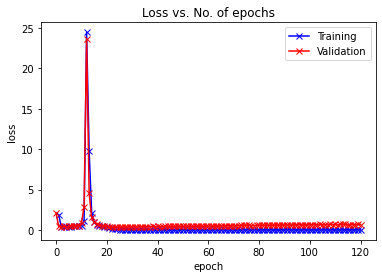

In [32]:
plot_losses(history)

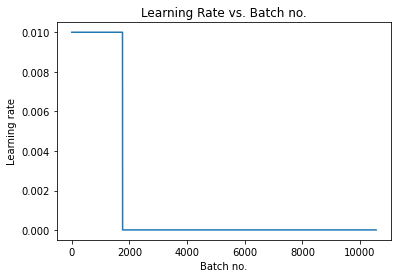

In [33]:
plot_lrs(history)

In [34]:
test_loader = DeviceDataLoader(test_dl, device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6128677129745483, 'val_acc': 0.9213088154792786}

In [35]:
torch.save(model, 'RESNEXT-50.pth')

### DenseNet121

In [37]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [38]:
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [39]:
model = nn.Sequential(
    model,
    nn.Linear(1000, 512, bias=True),
    nn.Linear(512, 64, bias=True),
    nn.Linear(64, 6, bias=True)
)
model = to_device(model, device)
# model

Sequential(
  (0): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, a

In [40]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.80591881275177, 'val_acc': 0.16255255043506622}]

In [41]:
for index, param in enumerate(model.parameters()):
    print(index, param.size())

0 torch.Size([64, 3, 7, 7])
1 torch.Size([64])
2 torch.Size([64])
3 torch.Size([64])
4 torch.Size([64])
5 torch.Size([128, 64, 1, 1])
6 torch.Size([128])
7 torch.Size([128])
8 torch.Size([32, 128, 3, 3])
9 torch.Size([96])
10 torch.Size([96])
11 torch.Size([128, 96, 1, 1])
12 torch.Size([128])
13 torch.Size([128])
14 torch.Size([32, 128, 3, 3])
15 torch.Size([128])
16 torch.Size([128])
17 torch.Size([128, 128, 1, 1])
18 torch.Size([128])
19 torch.Size([128])
20 torch.Size([32, 128, 3, 3])
21 torch.Size([160])
22 torch.Size([160])
23 torch.Size([128, 160, 1, 1])
24 torch.Size([128])
25 torch.Size([128])
26 torch.Size([32, 128, 3, 3])
27 torch.Size([192])
28 torch.Size([192])
29 torch.Size([128, 192, 1, 1])
30 torch.Size([128])
31 torch.Size([128])
32 torch.Size([32, 128, 3, 3])
33 torch.Size([224])
34 torch.Size([224])
35 torch.Size([128, 224, 1, 1])
36 torch.Size([128])
37 torch.Size([128])
38 torch.Size([32, 128, 3, 3])
39 torch.Size([256])
40 torch.Size([256])
41 torch.Size([128, 256

In [42]:
for index, param in enumerate(model.parameters()):
    param.requires_grad = True

In [43]:
for index, param in enumerate(model.parameters()):
    if index < 364:
        param.requires_grad = False

In [44]:
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [45]:
epochs = 100
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-8
opt_func = torch.optim.Adam

In [46]:
history += fit_one_cycle(20, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.01000, train_loss: 2.8174, val_loss: 0.4764, val_acc: 0.8321
Epoch [1], last_lr: 0.01000, train_loss: 0.4267, val_loss: 0.4216, val_acc: 0.8585
Epoch [2], last_lr: 0.01000, train_loss: 0.3812, val_loss: 0.3914, val_acc: 0.8592
Epoch [3], last_lr: 0.01000, train_loss: 0.3773, val_loss: 0.3920, val_acc: 0.8560
Epoch [4], last_lr: 0.01000, train_loss: 0.3663, val_loss: 0.4052, val_acc: 0.8521
Epoch [5], last_lr: 0.01000, train_loss: 0.3625, val_loss: 0.3725, val_acc: 0.8657
Epoch [6], last_lr: 0.01000, train_loss: 0.3729, val_loss: 0.4083, val_acc: 0.8574
Epoch [7], last_lr: 0.01000, train_loss: 0.3788, val_loss: 0.4570, val_acc: 0.8403
Epoch [8], last_lr: 0.01000, train_loss: 0.4451, val_loss: 0.5648, val_acc: 0.8232
Epoch [9], last_lr: 0.01000, train_loss: 0.4425, val_loss: 0.5134, val_acc: 0.8425
Epoch [10], last_lr: 0.01000, train_loss: 0.5382, val_loss: 0.5766, val_acc: 0.8311
Epoch [11], last_lr: 0.01000, train_loss: 0.6819, val_loss: 0.9762, val_acc: 0.8062
Ep

In [47]:
for index, param in enumerate(model.parameters()):
    param.requires_grad = True

In [48]:
epochs = 100
max_lr = 5e-5

In [49]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00005, train_loss: 0.2897, val_loss: 0.3168, val_acc: 0.8995
Epoch [1], last_lr: 0.00005, train_loss: 0.1218, val_loss: 0.3224, val_acc: 0.9012
Epoch [2], last_lr: 0.00005, train_loss: 0.0724, val_loss: 0.3080, val_acc: 0.9070
Epoch [3], last_lr: 0.00005, train_loss: 0.0507, val_loss: 0.3105, val_acc: 0.9056
Epoch [4], last_lr: 0.00005, train_loss: 0.0273, val_loss: 0.3265, val_acc: 0.9141
Epoch [5], last_lr: 0.00005, train_loss: 0.0200, val_loss: 0.3668, val_acc: 0.9141
Epoch [6], last_lr: 0.00005, train_loss: 0.0136, val_loss: 0.3690, val_acc: 0.9137
Epoch [7], last_lr: 0.00005, train_loss: 0.0114, val_loss: 0.4104, val_acc: 0.9144
Epoch [8], last_lr: 0.00005, train_loss: 0.0094, val_loss: 0.3869, val_acc: 0.9176
Epoch [9], last_lr: 0.00005, train_loss: 0.0067, val_loss: 0.4249, val_acc: 0.9187
Epoch [10], last_lr: 0.00005, train_loss: 0.0061, val_loss: 0.4366, val_acc: 0.9166
Epoch [11], last_lr: 0.00005, train_loss: 0.0064, val_loss: 0.4463, val_acc: 0.9119
Ep

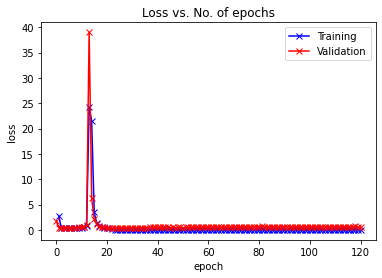

In [50]:
plot_losses(history)

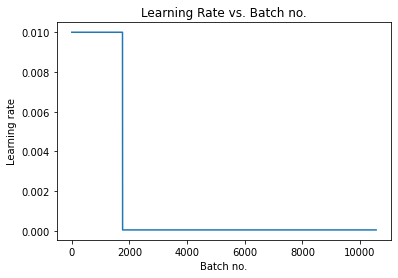

In [51]:
plot_lrs(history)

In [52]:
test_loader = DeviceDataLoader(test_dl, device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.46725279092788696, 'val_acc': 0.9291213154792786}

In [53]:
torch.save(model, 'DNET-50.pth')

### MobileNet

In [56]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
# model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [57]:
model = nn.Sequential(
    model,
    nn.Linear(1000, 512, bias=True),
    nn.Linear(512, 64, bias=True),
    nn.Linear(64, 6, bias=True)
)
model = to_device(model, device)
model

Sequential(
  (0): MobileNetV2(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=

In [58]:
for index,param in enumerate(model.parameters()):
    print(index, param.size())

0 torch.Size([32, 3, 3, 3])
1 torch.Size([32])
2 torch.Size([32])
3 torch.Size([32, 1, 3, 3])
4 torch.Size([32])
5 torch.Size([32])
6 torch.Size([16, 32, 1, 1])
7 torch.Size([16])
8 torch.Size([16])
9 torch.Size([96, 16, 1, 1])
10 torch.Size([96])
11 torch.Size([96])
12 torch.Size([96, 1, 3, 3])
13 torch.Size([96])
14 torch.Size([96])
15 torch.Size([24, 96, 1, 1])
16 torch.Size([24])
17 torch.Size([24])
18 torch.Size([144, 24, 1, 1])
19 torch.Size([144])
20 torch.Size([144])
21 torch.Size([144, 1, 3, 3])
22 torch.Size([144])
23 torch.Size([144])
24 torch.Size([24, 144, 1, 1])
25 torch.Size([24])
26 torch.Size([24])
27 torch.Size([144, 24, 1, 1])
28 torch.Size([144])
29 torch.Size([144])
30 torch.Size([144, 1, 3, 3])
31 torch.Size([144])
32 torch.Size([144])
33 torch.Size([32, 144, 1, 1])
34 torch.Size([32])
35 torch.Size([32])
36 torch.Size([192, 32, 1, 1])
37 torch.Size([192])
38 torch.Size([192])
39 torch.Size([192, 1, 3, 3])
40 torch.Size([192])
41 torch.Size([192])
42 torch.Size([3

In [59]:
for index, param in enumerate(model.parameters()):
    param.requires_grad = True

In [60]:
for index, param in enumerate(model.parameters()):
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [61]:
for index, param in enumerate(model.parameters()):
    if index < 158:
        param.requires_grad = False

In [62]:
for index, param in enumerate(model.parameters()):
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


In [63]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.0626449584960938, 'val_acc': 0.05345470830798149}]

In [64]:
epochs = 100
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-8
opt_func = torch.optim.Adam

In [67]:
history += fit_one_cycle(20, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.01000, train_loss: 1.7079, val_loss: 0.6349, val_acc: 0.7982
Epoch [1], last_lr: 0.01000, train_loss: 0.4596, val_loss: 0.4508, val_acc: 0.8484
Epoch [2], last_lr: 0.01000, train_loss: 0.4313, val_loss: 0.4775, val_acc: 0.8328
Epoch [3], last_lr: 0.01000, train_loss: 0.4332, val_loss: 0.4203, val_acc: 0.8558
Epoch [4], last_lr: 0.01000, train_loss: 0.5017, val_loss: 0.4923, val_acc: 0.8418
Epoch [5], last_lr: 0.01000, train_loss: 0.5656, val_loss: 0.8027, val_acc: 0.8207
Epoch [6], last_lr: 0.01000, train_loss: 12.0007, val_loss: 31.2984, val_acc: 0.7767
Epoch [7], last_lr: 0.01000, train_loss: 23.1427, val_loss: 6.6493, val_acc: 0.8396
Epoch [8], last_lr: 0.01000, train_loss: 4.0075, val_loss: 2.1915, val_acc: 0.8164
Epoch [9], last_lr: 0.01000, train_loss: 1.5332, val_loss: 1.0078, val_acc: 0.8391
Epoch [10], last_lr: 0.01000, train_loss: 0.8206, val_loss: 0.6191, val_acc: 0.8645
Epoch [11], last_lr: 0.01000, train_loss: 0.5326, val_loss: 0.5458, val_acc: 0.8397

In [68]:
for index, param in enumerate(model.parameters()):
    param.requires_grad = True

In [69]:
epochs = 100
max_lr = 2e-5

In [70]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00002, train_loss: 0.3021, val_loss: 0.3104, val_acc: 0.8920
Epoch [1], last_lr: 0.00002, train_loss: 0.2104, val_loss: 0.2838, val_acc: 0.8998
Epoch [2], last_lr: 0.00002, train_loss: 0.1713, val_loss: 0.2754, val_acc: 0.9045
Epoch [3], last_lr: 0.00002, train_loss: 0.1471, val_loss: 0.2714, val_acc: 0.9066
Epoch [4], last_lr: 0.00002, train_loss: 0.1199, val_loss: 0.2741, val_acc: 0.9127
Epoch [5], last_lr: 0.00002, train_loss: 0.1003, val_loss: 0.2827, val_acc: 0.9102
Epoch [6], last_lr: 0.00002, train_loss: 0.0898, val_loss: 0.2857, val_acc: 0.9116
Epoch [7], last_lr: 0.00002, train_loss: 0.0753, val_loss: 0.2912, val_acc: 0.9113
Epoch [8], last_lr: 0.00002, train_loss: 0.0612, val_loss: 0.3064, val_acc: 0.9134
Epoch [9], last_lr: 0.00002, train_loss: 0.0533, val_loss: 0.3089, val_acc: 0.9141
Epoch [10], last_lr: 0.00002, train_loss: 0.0414, val_loss: 0.3144, val_acc: 0.9163
Epoch [11], last_lr: 0.00002, train_loss: 0.0326, val_loss: 0.3248, val_acc: 0.9166
Ep

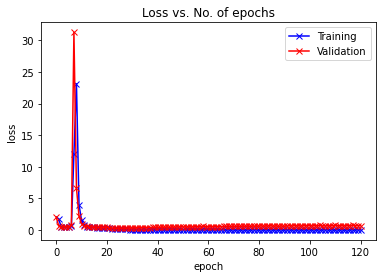

In [71]:
plot_losses(history)

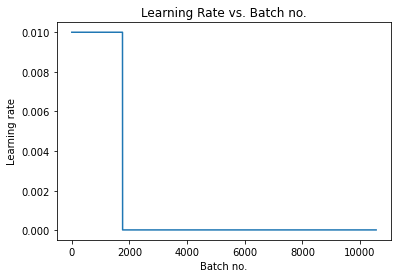

In [72]:
plot_lrs(history)

In [73]:
test_loader = DeviceDataLoader(test_dl, device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6436816453933716, 'val_acc': 0.9253425002098083}

In [74]:
torch.save(model, 'MobileNet.pth')

### ResNet 50

In [33]:
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
model.eval()

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
Downloading: "https://api.ngc.nvidia.com/v2/models/nvidia/resnet50_pyt_amp/versions/20.06.0/files/nvidia_resnet50_200821.pth.tar" to /root/.cache/torch/hub/checkpoints/nvidia_resnet50_200821.pth.tar


  0%|          | 0.00/97.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [34]:
model = nn.Sequential(
    model,
    nn.Linear(1000, 512, bias=True),
    nn.Linear(512, 64, bias = True),
    nn.Linear(64, 6, bias = True)
)
model = to_device(model, device)

In [35]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.723480224609375, 'val_acc': 0.33672279119491577}]

In [36]:
for index, param in enumerate(model.parameters()):
    print(index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166


In [37]:
for index, param in enumerate(model.parameters()):
    param.requires_grad = True

In [38]:
for index, param in enumerate(model.parameters()):
    if index < 159:
        param.requires_grad = False

In [39]:
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True


In [40]:
epochs = 100
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-8
opt_func = torch.optim.Adam

In [41]:
history += fit_one_cycle(20, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.01000, train_loss: 11.3478, val_loss: 0.7692, val_acc: 0.8396
Epoch [1], last_lr: 0.01000, train_loss: 0.3668, val_loss: 0.3607, val_acc: 0.8838
Epoch [2], last_lr: 0.01000, train_loss: 0.2806, val_loss: 0.3175, val_acc: 0.8891
Epoch [3], last_lr: 0.01000, train_loss: 0.2560, val_loss: 0.3071, val_acc: 0.8909
Epoch [4], last_lr: 0.01000, train_loss: 0.2355, val_loss: 0.3656, val_acc: 0.8735
Epoch [5], last_lr: 0.01000, train_loss: 0.2226, val_loss: 0.3510, val_acc: 0.8920
Epoch [6], last_lr: 0.01000, train_loss: 0.2248, val_loss: 0.3224, val_acc: 0.8910
Epoch [7], last_lr: 0.01000, train_loss: 0.2134, val_loss: 0.3201, val_acc: 0.8899
Epoch [8], last_lr: 0.01000, train_loss: 0.1924, val_loss: 0.4030, val_acc: 0.8643
Epoch [9], last_lr: 0.01000, train_loss: 0.1965, val_loss: 0.3736, val_acc: 0.8827
Epoch [10], last_lr: 0.01000, train_loss: 0.1721, val_loss: 0.3776, val_acc: 0.8860
Epoch [11], last_lr: 0.01000, train_loss: 0.1863, val_loss: 0.4075, val_acc: 0.8700
E

In [42]:
for index, param in enumerate(model.parameters()):
    param.requires_grad = True

In [43]:
epochs = 100
max_lr = 0.00005

In [ ]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00005, train_loss: 0.1269, val_loss: 0.3638, val_acc: 0.8977
Epoch [1], last_lr: 0.00005, train_loss: 0.0527, val_loss: 0.3915, val_acc: 0.9020
Epoch [2], last_lr: 0.00005, train_loss: 0.0319, val_loss: 0.3618, val_acc: 0.9073
Epoch [3], last_lr: 0.00005, train_loss: 0.0195, val_loss: 0.3942, val_acc: 0.9027
Epoch [4], last_lr: 0.00005, train_loss: 0.0148, val_loss: 0.4090, val_acc: 0.9091
Epoch [5], last_lr: 0.00005, train_loss: 0.0107, val_loss: 0.3952, val_acc: 0.9103
Epoch [6], last_lr: 0.00005, train_loss: 0.0061, val_loss: 0.4120, val_acc: 0.9102
Epoch [7], last_lr: 0.00005, train_loss: 0.0041, val_loss: 0.4137, val_acc: 0.9110
Epoch [8], last_lr: 0.00005, train_loss: 0.0056, val_loss: 0.4267, val_acc: 0.9120
Epoch [9], last_lr: 0.00005, train_loss: 0.0038, val_loss: 0.4531, val_acc: 0.9124
Epoch [10], last_lr: 0.00005, train_loss: 0.0051, val_loss: 0.4199, val_acc: 0.9141
Epoch [11], last_lr: 0.00005, train_loss: 0.0033, val_loss: 0.4474, val_acc: 0.9198
Ep

In [ ]:
plot_losses(history)

In [ ]:
plot_lrs(history)

In [ ]:
test_loader = DeviceDataLoader(test_dl, device)
result = evaluate(model, test_loader)
result

In [ ]:
torch.save(model, "RESNET-50.pth")

In [19]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
# model

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /root/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth


  0%|          | 0.00/132M [00:00<?, ?B/s]

In [20]:
model = nn.Sequential(
    model,
    nn.Linear(1000, 512, bias=True),
    nn.Linear(512, 64, bias = True),
    nn.Linear(64, 6, bias = True)
)
model = to_device(model, device)
# model

In [ ]:
for index, param in enumerate(model.parameters()):
    print(index, param.size())

In [21]:
for index, param in enumerate(model.parameters()):
    param.requires_grad = True

In [22]:
for index, param in enumerate(model.parameters()):
    if index < 161:
        param.requires_grad = False

In [ ]:
for index, param in enumerate(model.parameters()):
    print(index, param.size(), param.requires_grad)

In [23]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.9292958974838257, 'val_acc': 0.07952236384153366}]

In [24]:
epochs = 100
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-8
opt_func = torch.optim.Adam

In [25]:
history += fit_one_cycle(20, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.01000, train_loss: 2.3412, val_loss: 0.5279, val_acc: 0.8154
Epoch [1], last_lr: 0.01000, train_loss: 0.4436, val_loss: 0.4662, val_acc: 0.8308
Epoch [2], last_lr: 0.01000, train_loss: 0.4110, val_loss: 0.5656, val_acc: 0.8186
Epoch [3], last_lr: 0.01000, train_loss: 0.4394, val_loss: 0.4381, val_acc: 0.8394
Epoch [4], last_lr: 0.01000, train_loss: 0.4165, val_loss: 0.4731, val_acc: 0.8304
Epoch [5], last_lr: 0.01000, train_loss: 0.4268, val_loss: 0.4637, val_acc: 0.8294
Epoch [6], last_lr: 0.01000, train_loss: 0.4204, val_loss: 0.4829, val_acc: 0.8321
Epoch [7], last_lr: 0.01000, train_loss: 0.4140, val_loss: 0.4615, val_acc: 0.8236
Epoch [8], last_lr: 0.01000, train_loss: 0.4129, val_loss: 0.5291, val_acc: 0.8132
Epoch [9], last_lr: 0.01000, train_loss: 0.4781, val_loss: 0.5175, val_acc: 0.8218
Epoch [10], last_lr: 0.01000, train_loss: 0.4498, val_loss: 0.5606, val_acc: 0.8083
Epoch [11], last_lr: 0.01000, train_loss: 0.5284, val_loss: 0.5655, val_acc: 0.8239
Ep

In [26]:
for index, param in enumerate(model.parameters()):
    param.requires_grad = True

In [27]:
epochs = 100
max_lr = 5e-5

In [28]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00005, train_loss: 0.2758, val_loss: 0.2546, val_acc: 0.9127
Epoch [1], last_lr: 0.00005, train_loss: 0.0637, val_loss: 0.2657, val_acc: 0.9238
Epoch [2], last_lr: 0.00005, train_loss: 0.0288, val_loss: 0.2999, val_acc: 0.9224
Epoch [3], last_lr: 0.00005, train_loss: 0.0166, val_loss: 0.3131, val_acc: 0.9234
Epoch [4], last_lr: 0.00005, train_loss: 0.0113, val_loss: 0.3540, val_acc: 0.9270
Epoch [5], last_lr: 0.00005, train_loss: 0.0094, val_loss: 0.3612, val_acc: 0.9188
Epoch [6], last_lr: 0.00005, train_loss: 0.0043, val_loss: 0.3831, val_acc: 0.9234
Epoch [7], last_lr: 0.00005, train_loss: 0.0062, val_loss: 0.4473, val_acc: 0.9223
Epoch [8], last_lr: 0.00005, train_loss: 0.0146, val_loss: 0.4507, val_acc: 0.9159
Epoch [9], last_lr: 0.00005, train_loss: 0.0112, val_loss: 0.4107, val_acc: 0.9245
Epoch [10], last_lr: 0.00005, train_loss: 0.0190, val_loss: 0.4088, val_acc: 0.9220
Epoch [11], last_lr: 0.00005, train_loss: 0.0273, val_loss: 0.4496, val_acc: 0.9152
Ep

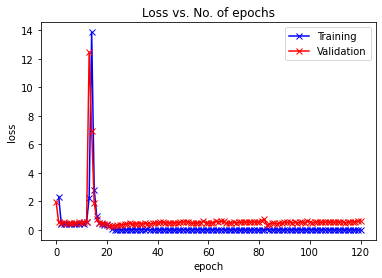

In [29]:
plot_losses(history)

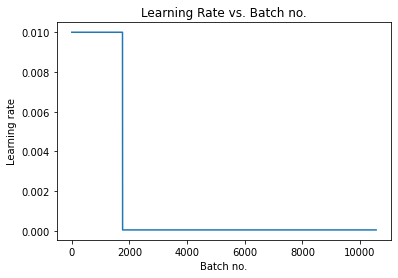

In [30]:
plot_lrs(history)

In [31]:
test_loader = DeviceDataLoader(test_dl, device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6041302680969238, 'val_acc': 0.9286684989929199}

In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model, batch) for batch in val_loader]
    return validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(filter(lambda p: p.requires_grad, model.parameters()), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
#     sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
#                                                 steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = training_step(model, batch)
            train_losses.append(loss)
            loss.backward()
            
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
#             sched.step()

        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        epoch_end(model, epoch, result)
        history.append(result)
    return history

In [32]:
torch.save(model, 'WRES-50.pth')

VGG16